In [1]:
import numpy as np
import matplotlib.pyplot as plt

from sklearn import metrics
from sklearn.metrics import classification_report
from sklearn import preprocessing

import keras
from keras.models import Sequential, Functional
from keras.layers import Dense, Dropout, Flatten, Reshape, TimeDistributed, GRU
from keras.layers import Conv1D, Conv2D, MaxPooling1D, MaxPooling2D
from keras.utils import np_utils
from tensorflow.keras import models, layers, utils, backend as K
from tensorflow.keras.optimizers import Adam, RMSprop

from keras.layers import Input
from keras.layers import Dense
from keras.layers import Concatenate

import tensorflow_ranking as tfr

In [2]:
#labels
LABELS = ['Standing',
          'Sitting',
          'Lying',
          'Squatting',
          'Walking',
          'Bending']

labeldict = {
0 : "Bring",
1 : "Clean Floor",
2 : "Clean Surface",
4 : "Close Door",
5 : "Close Drawer",
6 : "Close Lid By Rotate",
7 : "Close Other Lid",
8 : "Close Small Box",
9 : "Close Tap Water",
10 : "Drink",
11 : "Dry Off Hands",
12 : "Dry Off Hands By Shake",
13 : "Eat Small",
14 : "Gargle",
15 : "Getting Up",
16 : "Hang",
17 : "Lying Down",
18 : "Open Bag",
19 : "Open Big Box",
20 : "Open Door",
21 : "Open Drawer",
22 : "Open Lid By Rotate",
23 : "Open Other Lid",
24 : "Open Small Box",
25 : "Open Tap Water",
26 : "Plug In",
27 : "Press by Grasp",
28 : "Press From Top",
29 : "Press Switch",
30 : "Put From Bottle",
31 : "Put From Tap Water",
32 : "Put High Position",
33 : "Put On Floor",
34 : "Read",
35 : "Rotate",
36 : "Rub Hands",
37 : "Scoop And Put",
38 : "Sitting Down",
39 : "Squatting Down",
40 : "Standing Up",
41 : "Stand Up From Squatting",
42 : "Take From Floor",
43 : "Take From High Position",
44 : "Take Off Jacket",
45 : "Take Out",
46 : "Talk By Telephone",
47 : "Throw Out",
48 : "Throw Out Water",
49 : "Touch Smartphone Screen",
50 : "Type",
51 : "Unhang",
52 : "Unplug",
53 : "Wear Jacket",
54 : "Write"
}

#load data
#training
train_acc = np.load('../data/training/trainAccelerometer.npy')
train_gra = np.load('../data/training/trainGravity.npy')
train_gyr = np.load('../data/training/trainGyroscope.npy')
train_lin = np.load('../data/training/trainLinearAcceleration.npy')

train_mag = np.load('../data/training/trainMagnetometer800.npy')

trainJins_acc = np.load('../data/training/trainJinsAccelerometer800.npy')
trainJins_gyr = np.load('../data/training/trainJinsGyroscope800.npy')

trainMS_acc = np.load('../data/training/trainMSAccelerometer800.npy')
trainMS_gyr = np.load('../data/training/trainMSGyroscope800.npy')

train_label = np.load('../data/training/trainLabels.npy')

#train_data = [train_acc, train_gra, train_gyr, train_lin, train_mag, trainJins_acc, trainJins_gyr, trainMS_acc, trainMS_gyr]

test_acc = np.load('../data/testing/testAccelerometer.npy')
test_gra = np.load('../data/testing/testGravity.npy')
test_gyr = np.load('../data/testing/testGyroscope.npy')
test_mag = np.load('../data/testing/testMagnetometer800.npy')
test_lin = np.load('../data/testing/testLinearAcceleration.npy')

testJins_acc = np.load('../data/testing/testJinsAccelerometer800.npy')
testJins_gyr = np.load('../data/testing/testJinsGyroscope800.npy')

testMS_acc = np.load('../data/testing/testMSAccelerometer800.npy')
testMS_gyr = np.load('../data/testing/testMSGyroscope800.npy')

test_label = np.load('../data/testing/testLabels.npy')

#test_data = [test_acc, test_gra, test_gyr, test_lin, test_mag, testJins_acc, testJins_gyr, testMS_acc, testMS_gyr]

In [3]:
#ToDo: : smartphone/smartwatch placed in the left pocket/on the left arm differences 
#between left and right hand executions for some behavioural activities

In [4]:
#create input feature vector

#train vector
train_data_phone = [train_gyr, train_mag, train_lin]


train_features_phone = np.append(train_acc, train_gra, axis=2)
for i in train_data_phone:
    train_features_phone = np.append(train_features_phone, i, axis=2)
    
train_features_watch = np.append(trainMS_acc, trainMS_gyr, axis=2)
train_features_glasses = np.append(trainJins_acc, trainJins_gyr, axis=2)


print(train_features_watch.shape)
#print(train_features)


#test vector
test_data_phone = [test_gyr, test_mag, test_lin]
test_data_watch = [testMS_acc, testMS_gyr]
test_data_glasses = [testJins_acc, testJins_gyr]


test_features_phone = np.append(test_acc, test_gra, axis=2)
for i in test_data_phone:
    test_features_phone = np.append(test_features_phone, i, axis=2)
    
test_features_watch = np.append(testMS_acc, testMS_gyr, axis=2)
test_features_glasses = np.append(testJins_acc, testJins_gyr, axis=2)

    

print(test_features_phone.shape)
print(test_features_phone.shape[0])
print(test_features_phone.dtype)

#print(test_features[0])

(2284, 800, 6)
(2288, 800, 15)
2288
float32


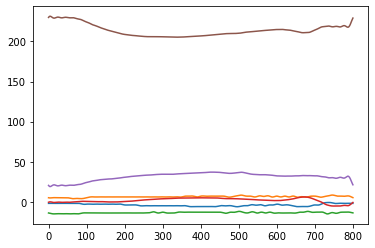

Open Bag


In [5]:
#print(test_label)
#print(train_features)
#all samples of first activity
n = 18
plt.plot(train_features_glasses[n])
plt.show()
print(labeldict[n])

#numeric values can be misinterpreted by algorithms as having some sort of hierarchy/order in them
#done with one-hot-encoding
y_train_hot = np_utils.to_categorical(train_label, num_classes)
print('New y_train shape: ', y_train_hot.shape)

In [6]:

#number of hidden layer: around (number of inputs + 1)/2

#(input: ?-dimensional vectors) 
#       ↧

#.
#.
#.
#       ↧
#[Dense (1? units, softmax activation)]
#       ↧
#(output: integer for human activity (0-54))

#training data:
X_train_phone = train_features_phone
X_train_watch = train_features_watch
X_train_glasses = train_features_glasses
Y_train = train_label

X_test_phone = test_features_phone
X_test_watch = test_features_watch
X_test_glasses = test_features_glasses
Y_test = test_label

In [7]:
verbose, epochs, batch_size = 2, 100, 64
n_timesteps, n_features, n_outputs = 800, 27, 55

input_phone = Input(shape=(n_timesteps,15), name='phone')
conv1D = Conv1D(filters=100, kernel_size=5, activation='relu')(input_phone)
drop1 = Dropout(0.5)(conv1D)
pool1 = MaxPooling1D(pool_size=5)(drop1)
# model.add(Flatten())
drop2 = Dropout(0.5)(pool1)
conv1D_2 = Conv1D(filters=100, kernel_size=5, activation='relu')(drop2)
dens1 = Dense(8, activation='relu')(conv1D_2)
# drop3 = Dropout(0.5)(dens1)
flatten = Flatten()(dens1)
output_phone = Dense(55, activation='softmax')(flatten)



input_watch = Input(shape=(n_timesteps,6), name='watch')
conv1D_watch = Conv1D(filters=100, kernel_size=5, activation='relu')(input_watch)
drop1_watch = Dropout(0.5)(conv1D_watch)
pool1_watch = MaxPooling1D(pool_size=5)(drop1_watch)
# model.add(Flatten())
drop2_watch = Dropout(0.5)(pool1_watch)
conv1D_watch = Conv1D(filters=100, kernel_size=5, activation='relu')(drop2_watch)
dens1_watch = Dense(8, activation='relu')(conv1D_watch)
# drop3_watch = Dropout(0.5)(dens1_watch)
flatten_watch = Flatten()(dens1_watch)
output_watch = Dense(55, activation='softmax')(flatten_watch)



input_glasses = Input(shape=(n_timesteps,6), name='glasses')
conv1D_glasses = Conv1D(filters=100, kernel_size=5, activation='relu')(input_glasses)
drop1_glasses = Dropout(0.5)(conv1D_glasses)
pool1_glasses = MaxPooling1D(pool_size=5)(drop1_glasses)
# model.add(Flatten())
drop2_glasses = Dropout(0.5)(pool1_glasses)
conv1D_glasses_2 = Conv1D(filters=100, kernel_size=5, activation='relu')(drop2_glasses)
dens1_glasses = Dense(8, activation='relu')(conv1D_glasses_2)
# drop3_glasses = Dropout(0.5)(dens1_glasses)
flatten_glasses = Flatten()(dens1_glasses)
output_glasses = Dense(55, activation='softmax')(flatten_glasses)



combined_models = layers.Concatenate()([output_phone, output_watch, output_glasses])
reshaped = Reshape((55, 3))(combined_models)
conv1D_combined = Conv1D(filters=8, kernel_size=5, activation='relu')(reshaped)
drop1_combined = Dropout(0.5)(conv1D_combined)
flatten = Flatten()(drop1_combined)
output = Dense(55, activation='softmax')(flatten)

model = Functional(inputs=[input_phone, input_watch, input_glasses], outputs=output)

print(model.summary())


Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 phone (InputLayer)             [(None, 800, 15)]    0           []                               
                                                                                                  
 watch (InputLayer)             [(None, 800, 6)]     0           []                               
                                                                                                  
 glasses (InputLayer)           [(None, 800, 6)]     0           []                               
                                                                                                  
 conv1d (Conv1D)                (None, 796, 100)     7600        ['phone[0][0]']                  
                                                                                              

In [8]:
def Recall(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    possible_positives = K.sum(K.round(K.clip(y_true, 0, 1)))
    recall = true_positives / (possible_positives + K.epsilon())
    return recall

def Precision(y_true, y_pred):
    true_positives = K.sum(K.round(K.clip(y_true * y_pred, 0, 1)))
    predicted_positives = K.sum(K.round(K.clip(y_pred, 0, 1)))
    precision = true_positives / (predicted_positives + K.epsilon())
    return precision

def F1(y_true, y_pred):
    precision = Precision(y_true, y_pred)
    recall = Recall(y_true, y_pred)
    return 2*((precision*recall)/(precision+recall+K.epsilon()))

def computeMeanAveragePrecision(labels,softmaxEstimations):

    nbExamples , nbClasses = softmaxEstimations.shape

    averagePrecisions = np.zeros((nbClasses),dtype=np.float32)

    # For all classes
    for classIdx in range(nbClasses):

        # Sort the softmaxEstimations by decreasing order, and keep the order consistent with the labels
        permutation = list(reversed(np.argsort(softmaxEstimations[:,classIdx])))
        labelArray = np.asarray(labels)
        labelsTmp = list(labelArray[permutation])

        # Convert the labels to binary (1-vs-all)
        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == classIdx:
                labelsTmp[idx] = 1
            else:
                labelsTmp[idx] = 0

        # Compute the averaged sum of precisions by descending order
        nbPrecisionComputations = 0
        averagePrecisionSum = 0

        for idx in range(len(labelsTmp)):
            if labelsTmp[idx] == 1:
                averagePrecisionSum += np.sum(labelsTmp[:idx+1])/float(idx+1)
                nbPrecisionComputations += 1

        if nbPrecisionComputations == 0:
             averagePrecisions[classIdx] = 0
        else:
            averagePrecisions[classIdx] = averagePrecisionSum/float(nbPrecisionComputations)

    # Return global MAP and class MAPs
    return np.mean(averagePrecisions), averagePrecisions



model.compile(
    loss=keras.losses.CategoricalCrossentropy(),
    optimizer=Adam(learning_rate=0.0001),
    metrics=['accuracy', F1, tfr.keras.metrics.MeanAveragePrecisionMetric()]
)

callbacks_list = [
    #keras.callbacks.ModelCheckpoint(filepath='best_model.{epoch:02d}-{val_loss:.2f}.h5', monitor='val_loss', save_best_only=True),
keras.callbacks.EarlyStopping(monitor='loss', patience=3)
]

y_train_hot = np_utils.to_categorical(train_label, 55)
y_test_hot = np_utils.to_categorical(test_label, 55)
print('New y_train shape: ', y_train_hot.shape)


New y_train shape:  (2284, 55)


In [9]:
# run an experiment
def run_experiment():
    # load data
    # repeat experiment
    scores = list()
    
    history = model.fit({"phone": train_features_phone, "watch": train_features_watch, "glasses": train_features_glasses}, y_train_hot, batch_size=32, epochs=800, validation_split=0.2)
    score = model.evaluate({"phone": test_features_phone, "watch": test_features_watch, "glasses": test_features_glasses}, y_test_hot, verbose=2)
    scores.append(score)
    # summarize results
    print("Test loss:", scores[0])
    return history

In [10]:
history = run_experiment()

Epoch 1/800
58/58 [==============================] - 6s 74ms/step - loss: 4.0130 - accuracy: 0.0224 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0885 - val_loss: 4.0100 - val_accuracy: 0.0284 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0975
Epoch 2/800
58/58 [==============================] - 4s 66ms/step - loss: 4.0068 - accuracy: 0.0197 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0917 - val_loss: 4.0073 - val_accuracy: 0.0241 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0949
Epoch 3/800
58/58 [==============================] - 4s 66ms/step - loss: 4.0063 - accuracy: 0.0285 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0950 - val_loss: 4.0009 - val_accuracy: 0.0219 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.0976
Epoch 4/800
58/58 [==============================] - 4s 67ms/step - loss: 4.0019 - accuracy: 0.0186 - F1: 0.0000e+00 - mean_average_precision_metric: 0.0891 - val_loss: 3.9990 - val_accuracy: 0.0263 - val_F1:

Epoch 32/800
58/58 [==============================] - 4s 68ms/step - loss: 3.7751 - accuracy: 0.0843 - F1: 0.0000e+00 - mean_average_precision_metric: 0.2001 - val_loss: 3.8287 - val_accuracy: 0.0460 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.1581
Epoch 33/800
58/58 [==============================] - 4s 69ms/step - loss: 3.7439 - accuracy: 0.0892 - F1: 0.0000e+00 - mean_average_precision_metric: 0.2166 - val_loss: 3.8100 - val_accuracy: 0.0591 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.1757
Epoch 34/800
58/58 [==============================] - 4s 68ms/step - loss: 3.7397 - accuracy: 0.0930 - F1: 0.0000e+00 - mean_average_precision_metric: 0.2203 - val_loss: 3.7994 - val_accuracy: 0.0569 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.1756
Epoch 35/800
58/58 [==============================] - 4s 66ms/step - loss: 3.7236 - accuracy: 0.1034 - F1: 0.0000e+00 - mean_average_precision_metric: 0.2279 - val_loss: 3.7822 - val_accuracy: 0.0635 - val

Epoch 63/800
58/58 [==============================] - 4s 69ms/step - loss: 3.2741 - accuracy: 0.1653 - F1: 0.0000e+00 - mean_average_precision_metric: 0.3203 - val_loss: 3.4300 - val_accuracy: 0.0963 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2502
Epoch 64/800
58/58 [==============================] - 4s 69ms/step - loss: 3.2800 - accuracy: 0.1440 - F1: 0.0000e+00 - mean_average_precision_metric: 0.3045 - val_loss: 3.4211 - val_accuracy: 0.0963 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2529
Epoch 65/800
58/58 [==============================] - 4s 69ms/step - loss: 3.2619 - accuracy: 0.1653 - F1: 0.0000e+00 - mean_average_precision_metric: 0.3174 - val_loss: 3.4177 - val_accuracy: 0.0941 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2523
Epoch 66/800
58/58 [==============================] - 4s 70ms/step - loss: 3.2473 - accuracy: 0.1582 - F1: 0.0000e+00 - mean_average_precision_metric: 0.3131 - val_loss: 3.4128 - val_accuracy: 0.1072 - val

58/58 [==============================] - 4s 67ms/step - loss: 3.0081 - accuracy: 0.1981 - F1: 0.0094 - mean_average_precision_metric: 0.3528 - val_loss: 3.2236 - val_accuracy: 0.1335 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2842
Epoch 95/800
58/58 [==============================] - 4s 69ms/step - loss: 2.9898 - accuracy: 0.1954 - F1: 0.0093 - mean_average_precision_metric: 0.3543 - val_loss: 3.1904 - val_accuracy: 0.1422 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2989
Epoch 96/800
58/58 [==============================] - 4s 68ms/step - loss: 2.9690 - accuracy: 0.2085 - F1: 0.0143 - mean_average_precision_metric: 0.3668 - val_loss: 3.1873 - val_accuracy: 0.1379 - val_F1: 0.0000e+00 - val_mean_average_precision_metric: 0.2957
Epoch 97/800
58/58 [==============================] - 4s 67ms/step - loss: 2.9372 - accuracy: 0.2184 - F1: 0.0143 - mean_average_precision_metric: 0.3779 - val_loss: 3.1732 - val_accuracy: 0.1466 - val_F1: 0.0000e+00 - val_mean_av

58/58 [==============================] - 4s 66ms/step - loss: 2.7561 - accuracy: 0.2326 - F1: 0.0435 - mean_average_precision_metric: 0.4033 - val_loss: 3.0291 - val_accuracy: 0.1926 - val_F1: 0.0121 - val_mean_average_precision_metric: 0.3496
Epoch 126/800
58/58 [==============================] - 4s 67ms/step - loss: 2.7291 - accuracy: 0.2430 - F1: 0.0467 - mean_average_precision_metric: 0.4158 - val_loss: 3.0680 - val_accuracy: 0.1707 - val_F1: 0.0081 - val_mean_average_precision_metric: 0.3290
Epoch 127/800
58/58 [==============================] - 4s 68ms/step - loss: 2.7200 - accuracy: 0.2523 - F1: 0.0406 - mean_average_precision_metric: 0.4195 - val_loss: 3.0187 - val_accuracy: 0.1772 - val_F1: 0.0121 - val_mean_average_precision_metric: 0.3416
Epoch 128/800
58/58 [==============================] - 4s 67ms/step - loss: 2.7084 - accuracy: 0.2408 - F1: 0.0505 - mean_average_precision_metric: 0.4152 - val_loss: 3.0024 - val_accuracy: 0.1947 - val_F1: 0.0198 - val_mean_average_precisi

Epoch 157/800
58/58 [==============================] - 4s 66ms/step - loss: 2.5791 - accuracy: 0.2813 - F1: 0.0601 - mean_average_precision_metric: 0.4479 - val_loss: 2.9513 - val_accuracy: 0.1882 - val_F1: 0.0240 - val_mean_average_precision_metric: 0.3571
Epoch 158/800
58/58 [==============================] - 4s 66ms/step - loss: 2.5745 - accuracy: 0.2677 - F1: 0.0833 - mean_average_precision_metric: 0.4411 - val_loss: 2.9795 - val_accuracy: 0.1969 - val_F1: 0.0197 - val_mean_average_precision_metric: 0.3575
Epoch 159/800
58/58 [==============================] - 4s 67ms/step - loss: 2.5815 - accuracy: 0.2644 - F1: 0.0740 - mean_average_precision_metric: 0.4374 - val_loss: 2.9283 - val_accuracy: 0.1926 - val_F1: 0.0235 - val_mean_average_precision_metric: 0.3597
Epoch 160/800
58/58 [==============================] - 4s 66ms/step - loss: 2.5533 - accuracy: 0.2770 - F1: 0.0768 - mean_average_precision_metric: 0.4476 - val_loss: 2.9372 - val_accuracy: 0.1969 - val_F1: 0.0234 - val_mean_a

Epoch 189/800
58/58 [==============================] - 4s 72ms/step - loss: 2.4520 - accuracy: 0.3093 - F1: 0.1188 - mean_average_precision_metric: 0.4752 - val_loss: 2.9068 - val_accuracy: 0.2101 - val_F1: 0.0539 - val_mean_average_precision_metric: 0.3724
Epoch 190/800
58/58 [==============================] - 4s 71ms/step - loss: 2.4328 - accuracy: 0.3180 - F1: 0.1131 - mean_average_precision_metric: 0.4816 - val_loss: 2.8792 - val_accuracy: 0.2101 - val_F1: 0.0653 - val_mean_average_precision_metric: 0.3760
Epoch 191/800
58/58 [==============================] - 4s 69ms/step - loss: 2.4228 - accuracy: 0.3016 - F1: 0.1075 - mean_average_precision_metric: 0.4763 - val_loss: 2.8747 - val_accuracy: 0.2101 - val_F1: 0.0540 - val_mean_average_precision_metric: 0.3765
Epoch 192/800
58/58 [==============================] - 4s 70ms/step - loss: 2.4333 - accuracy: 0.2928 - F1: 0.1216 - mean_average_precision_metric: 0.4671 - val_loss: 2.8523 - val_accuracy: 0.2035 - val_F1: 0.0659 - val_mean_a

Epoch 221/800
58/58 [==============================] - 4s 69ms/step - loss: 2.2874 - accuracy: 0.3328 - F1: 0.1417 - mean_average_precision_metric: 0.5075 - val_loss: 2.8994 - val_accuracy: 0.2123 - val_F1: 0.0747 - val_mean_average_precision_metric: 0.3808
Epoch 222/800
58/58 [==============================] - 4s 68ms/step - loss: 2.3176 - accuracy: 0.3300 - F1: 0.1473 - mean_average_precision_metric: 0.4980 - val_loss: 2.9028 - val_accuracy: 0.2101 - val_F1: 0.0818 - val_mean_average_precision_metric: 0.3789
Epoch 223/800
58/58 [==============================] - 4s 69ms/step - loss: 2.3594 - accuracy: 0.3262 - F1: 0.1507 - mean_average_precision_metric: 0.4989 - val_loss: 3.0174 - val_accuracy: 0.1991 - val_F1: 0.0607 - val_mean_average_precision_metric: 0.3661
Epoch 224/800
58/58 [==============================] - 4s 68ms/step - loss: 2.3498 - accuracy: 0.3268 - F1: 0.1522 - mean_average_precision_metric: 0.4966 - val_loss: 2.9592 - val_accuracy: 0.2210 - val_F1: 0.0763 - val_mean_a

Epoch 253/800
58/58 [==============================] - 4s 68ms/step - loss: 2.1815 - accuracy: 0.3547 - F1: 0.1795 - mean_average_precision_metric: 0.5268 - val_loss: 2.9039 - val_accuracy: 0.2232 - val_F1: 0.0959 - val_mean_average_precision_metric: 0.3931
Epoch 254/800
58/58 [==============================] - 4s 68ms/step - loss: 2.1996 - accuracy: 0.3530 - F1: 0.1750 - mean_average_precision_metric: 0.5236 - val_loss: 2.8896 - val_accuracy: 0.2385 - val_F1: 0.0932 - val_mean_average_precision_metric: 0.4045
Epoch 255/800
58/58 [==============================] - 4s 68ms/step - loss: 2.2127 - accuracy: 0.3656 - F1: 0.1839 - mean_average_precision_metric: 0.5323 - val_loss: 2.8952 - val_accuracy: 0.2276 - val_F1: 0.0927 - val_mean_average_precision_metric: 0.3990
Epoch 256/800
58/58 [==============================] - 4s 68ms/step - loss: 2.1768 - accuracy: 0.3547 - F1: 0.1832 - mean_average_precision_metric: 0.5327 - val_loss: 2.8849 - val_accuracy: 0.2363 - val_F1: 0.0962 - val_mean_a

Epoch 285/800
58/58 [==============================] - 4s 68ms/step - loss: 2.0942 - accuracy: 0.3870 - F1: 0.2159 - mean_average_precision_metric: 0.5551 - val_loss: 2.8185 - val_accuracy: 0.2560 - val_F1: 0.1167 - val_mean_average_precision_metric: 0.4265
Epoch 286/800
58/58 [==============================] - 4s 67ms/step - loss: 2.1296 - accuracy: 0.3804 - F1: 0.2127 - mean_average_precision_metric: 0.5488 - val_loss: 2.8113 - val_accuracy: 0.2429 - val_F1: 0.1192 - val_mean_average_precision_metric: 0.4185
Epoch 287/800
58/58 [==============================] - 4s 68ms/step - loss: 2.1342 - accuracy: 0.3766 - F1: 0.2104 - mean_average_precision_metric: 0.5475 - val_loss: 2.8472 - val_accuracy: 0.2429 - val_F1: 0.1189 - val_mean_average_precision_metric: 0.4160
Epoch 288/800
58/58 [==============================] - 4s 69ms/step - loss: 2.0551 - accuracy: 0.3826 - F1: 0.2345 - mean_average_precision_metric: 0.5544 - val_loss: 2.8619 - val_accuracy: 0.2385 - val_F1: 0.1157 - val_mean_a

Epoch 317/800
58/58 [==============================] - 4s 68ms/step - loss: 2.0246 - accuracy: 0.3930 - F1: 0.2431 - mean_average_precision_metric: 0.5628 - val_loss: 2.8867 - val_accuracy: 0.2429 - val_F1: 0.1230 - val_mean_average_precision_metric: 0.4150
Epoch 318/800
58/58 [==============================] - 4s 69ms/step - loss: 2.0111 - accuracy: 0.4012 - F1: 0.2327 - mean_average_precision_metric: 0.5710 - val_loss: 2.8939 - val_accuracy: 0.2516 - val_F1: 0.1162 - val_mean_average_precision_metric: 0.4174
Epoch 319/800
58/58 [==============================] - 4s 68ms/step - loss: 1.9972 - accuracy: 0.4116 - F1: 0.2500 - mean_average_precision_metric: 0.5776 - val_loss: 2.9128 - val_accuracy: 0.2473 - val_F1: 0.1120 - val_mean_average_precision_metric: 0.4128
Epoch 320/800
58/58 [==============================] - 4s 69ms/step - loss: 2.0001 - accuracy: 0.4111 - F1: 0.2437 - mean_average_precision_metric: 0.5769 - val_loss: 2.9362 - val_accuracy: 0.2429 - val_F1: 0.1140 - val_mean_a

Epoch 349/800
58/58 [==============================] - 4s 72ms/step - loss: 1.9684 - accuracy: 0.4264 - F1: 0.2567 - mean_average_precision_metric: 0.5877 - val_loss: 2.8452 - val_accuracy: 0.2560 - val_F1: 0.1269 - val_mean_average_precision_metric: 0.4265
Epoch 350/800
58/58 [==============================] - 4s 70ms/step - loss: 1.8971 - accuracy: 0.4324 - F1: 0.2718 - mean_average_precision_metric: 0.5984 - val_loss: 2.9152 - val_accuracy: 0.2516 - val_F1: 0.1233 - val_mean_average_precision_metric: 0.4119
Epoch 351/800
58/58 [==============================] - 4s 68ms/step - loss: 1.9103 - accuracy: 0.4193 - F1: 0.2853 - mean_average_precision_metric: 0.5888 - val_loss: 2.9163 - val_accuracy: 0.2604 - val_F1: 0.1330 - val_mean_average_precision_metric: 0.4251
Epoch 352/800
58/58 [==============================] - 4s 68ms/step - loss: 1.9559 - accuracy: 0.4269 - F1: 0.2746 - mean_average_precision_metric: 0.5878 - val_loss: 2.8916 - val_accuracy: 0.2670 - val_F1: 0.1396 - val_mean_a

Epoch 381/800
58/58 [==============================] - 4s 71ms/step - loss: 1.9856 - accuracy: 0.4001 - F1: 0.2877 - mean_average_precision_metric: 0.5676 - val_loss: 2.9240 - val_accuracy: 0.2648 - val_F1: 0.1508 - val_mean_average_precision_metric: 0.4240
Epoch 382/800
58/58 [==============================] - 4s 70ms/step - loss: 1.9379 - accuracy: 0.4089 - F1: 0.3083 - mean_average_precision_metric: 0.5756 - val_loss: 2.9173 - val_accuracy: 0.2735 - val_F1: 0.1559 - val_mean_average_precision_metric: 0.4343
Epoch 383/800
58/58 [==============================] - 4s 69ms/step - loss: 1.8828 - accuracy: 0.4264 - F1: 0.3000 - mean_average_precision_metric: 0.5935 - val_loss: 2.8757 - val_accuracy: 0.2670 - val_F1: 0.1570 - val_mean_average_precision_metric: 0.4298
Epoch 384/800
58/58 [==============================] - 4s 70ms/step - loss: 1.8527 - accuracy: 0.4384 - F1: 0.3131 - mean_average_precision_metric: 0.6027 - val_loss: 2.9051 - val_accuracy: 0.2670 - val_F1: 0.1577 - val_mean_a

Epoch 413/800
58/58 [==============================] - 4s 69ms/step - loss: 1.7986 - accuracy: 0.4576 - F1: 0.3296 - mean_average_precision_metric: 0.6175 - val_loss: 2.8813 - val_accuracy: 0.2757 - val_F1: 0.1922 - val_mean_average_precision_metric: 0.4402
Epoch 414/800
58/58 [==============================] - 4s 68ms/step - loss: 1.8311 - accuracy: 0.4433 - F1: 0.3356 - mean_average_precision_metric: 0.6076 - val_loss: 2.8990 - val_accuracy: 0.2670 - val_F1: 0.1810 - val_mean_average_precision_metric: 0.4344
Epoch 415/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7992 - accuracy: 0.4510 - F1: 0.3385 - mean_average_precision_metric: 0.6146 - val_loss: 3.0095 - val_accuracy: 0.2648 - val_F1: 0.1758 - val_mean_average_precision_metric: 0.4265
Epoch 416/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7871 - accuracy: 0.4527 - F1: 0.3152 - mean_average_precision_metric: 0.6166 - val_loss: 3.0345 - val_accuracy: 0.2538 - val_F1: 0.1755 - val_mean_a

Epoch 445/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7698 - accuracy: 0.4543 - F1: 0.3513 - mean_average_precision_metric: 0.6225 - val_loss: 3.0832 - val_accuracy: 0.2451 - val_F1: 0.1890 - val_mean_average_precision_metric: 0.4193
Epoch 446/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7510 - accuracy: 0.4691 - F1: 0.3424 - mean_average_precision_metric: 0.6266 - val_loss: 3.0804 - val_accuracy: 0.2691 - val_F1: 0.1963 - val_mean_average_precision_metric: 0.4317
Epoch 447/800
58/58 [==============================] - 4s 70ms/step - loss: 1.7834 - accuracy: 0.4587 - F1: 0.3532 - mean_average_precision_metric: 0.6205 - val_loss: 3.0929 - val_accuracy: 0.2560 - val_F1: 0.1973 - val_mean_average_precision_metric: 0.4209
Epoch 448/800
58/58 [==============================] - 4s 69ms/step - loss: 1.7729 - accuracy: 0.4620 - F1: 0.3486 - mean_average_precision_metric: 0.6201 - val_loss: 2.9907 - val_accuracy: 0.2648 - val_F1: 0.1970 - val_mean_a

Epoch 477/800
58/58 [==============================] - 4s 69ms/step - loss: 1.7035 - accuracy: 0.4756 - F1: 0.3706 - mean_average_precision_metric: 0.6343 - val_loss: 3.0689 - val_accuracy: 0.2604 - val_F1: 0.2022 - val_mean_average_precision_metric: 0.4289
Epoch 478/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7102 - accuracy: 0.4773 - F1: 0.3668 - mean_average_precision_metric: 0.6368 - val_loss: 3.0297 - val_accuracy: 0.2604 - val_F1: 0.2050 - val_mean_average_precision_metric: 0.4291
Epoch 479/800
58/58 [==============================] - 4s 68ms/step - loss: 1.6875 - accuracy: 0.4789 - F1: 0.3815 - mean_average_precision_metric: 0.6385 - val_loss: 2.9917 - val_accuracy: 0.2670 - val_F1: 0.2063 - val_mean_average_precision_metric: 0.4350
Epoch 480/800
58/58 [==============================] - 4s 68ms/step - loss: 1.6939 - accuracy: 0.4598 - F1: 0.3664 - mean_average_precision_metric: 0.6321 - val_loss: 2.9730 - val_accuracy: 0.2648 - val_F1: 0.2069 - val_mean_a

Epoch 509/800
58/58 [==============================] - 4s 69ms/step - loss: 1.6211 - accuracy: 0.5096 - F1: 0.4064 - mean_average_precision_metric: 0.6603 - val_loss: 3.1980 - val_accuracy: 0.2626 - val_F1: 0.2057 - val_mean_average_precision_metric: 0.4275
Epoch 510/800
58/58 [==============================] - 4s 68ms/step - loss: 1.7058 - accuracy: 0.4882 - F1: 0.3987 - mean_average_precision_metric: 0.6421 - val_loss: 3.0950 - val_accuracy: 0.2560 - val_F1: 0.2090 - val_mean_average_precision_metric: 0.4247
Epoch 511/800
58/58 [==============================] - 4s 68ms/step - loss: 1.6644 - accuracy: 0.4839 - F1: 0.3902 - mean_average_precision_metric: 0.6435 - val_loss: 3.1029 - val_accuracy: 0.2604 - val_F1: 0.2095 - val_mean_average_precision_metric: 0.4240
Epoch 512/800
58/58 [==============================] - 4s 68ms/step - loss: 1.6636 - accuracy: 0.4756 - F1: 0.3786 - mean_average_precision_metric: 0.6408 - val_loss: 3.0676 - val_accuracy: 0.2604 - val_F1: 0.2233 - val_mean_a

Epoch 541/800
58/58 [==============================] - 4s 69ms/step - loss: 1.5803 - accuracy: 0.5101 - F1: 0.4235 - mean_average_precision_metric: 0.6630 - val_loss: 3.2009 - val_accuracy: 0.2691 - val_F1: 0.2178 - val_mean_average_precision_metric: 0.4287
Epoch 542/800
58/58 [==============================] - 4s 69ms/step - loss: 1.5776 - accuracy: 0.5041 - F1: 0.4038 - mean_average_precision_metric: 0.6622 - val_loss: 3.1070 - val_accuracy: 0.2801 - val_F1: 0.2455 - val_mean_average_precision_metric: 0.4407
Epoch 543/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5968 - accuracy: 0.5052 - F1: 0.4070 - mean_average_precision_metric: 0.6619 - val_loss: 3.1591 - val_accuracy: 0.2757 - val_F1: 0.2226 - val_mean_average_precision_metric: 0.4386
Epoch 544/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5795 - accuracy: 0.5140 - F1: 0.4341 - mean_average_precision_metric: 0.6642 - val_loss: 3.1140 - val_accuracy: 0.2823 - val_F1: 0.2350 - val_mean_a

Epoch 573/800
58/58 [==============================] - 4s 71ms/step - loss: 1.5515 - accuracy: 0.5134 - F1: 0.4209 - mean_average_precision_metric: 0.6676 - val_loss: 3.2931 - val_accuracy: 0.2604 - val_F1: 0.2099 - val_mean_average_precision_metric: 0.4273
Epoch 574/800
58/58 [==============================] - 4s 71ms/step - loss: 1.5489 - accuracy: 0.5282 - F1: 0.4293 - mean_average_precision_metric: 0.6769 - val_loss: 3.2679 - val_accuracy: 0.2604 - val_F1: 0.1994 - val_mean_average_precision_metric: 0.4274
Epoch 575/800
58/58 [==============================] - 4s 70ms/step - loss: 1.5408 - accuracy: 0.5211 - F1: 0.4203 - mean_average_precision_metric: 0.6726 - val_loss: 3.2954 - val_accuracy: 0.2560 - val_F1: 0.1995 - val_mean_average_precision_metric: 0.4237
Epoch 576/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5477 - accuracy: 0.5151 - F1: 0.4293 - mean_average_precision_metric: 0.6714 - val_loss: 3.2525 - val_accuracy: 0.2604 - val_F1: 0.2037 - val_mean_a

Epoch 605/800
58/58 [==============================] - 4s 71ms/step - loss: 1.5403 - accuracy: 0.5090 - F1: 0.4291 - mean_average_precision_metric: 0.6695 - val_loss: 3.3152 - val_accuracy: 0.2735 - val_F1: 0.2146 - val_mean_average_precision_metric: 0.4397
Epoch 606/800
58/58 [==============================] - 4s 71ms/step - loss: 1.5400 - accuracy: 0.5238 - F1: 0.4364 - mean_average_precision_metric: 0.6724 - val_loss: 3.2785 - val_accuracy: 0.2735 - val_F1: 0.2449 - val_mean_average_precision_metric: 0.4316
Epoch 607/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5372 - accuracy: 0.5216 - F1: 0.4404 - mean_average_precision_metric: 0.6717 - val_loss: 3.2594 - val_accuracy: 0.2735 - val_F1: 0.2189 - val_mean_average_precision_metric: 0.4345
Epoch 608/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5552 - accuracy: 0.5145 - F1: 0.4065 - mean_average_precision_metric: 0.6694 - val_loss: 3.1954 - val_accuracy: 0.2888 - val_F1: 0.2383 - val_mean_a

Epoch 637/800
58/58 [==============================] - 4s 68ms/step - loss: 1.4891 - accuracy: 0.5260 - F1: 0.4418 - mean_average_precision_metric: 0.6804 - val_loss: 3.4025 - val_accuracy: 0.2801 - val_F1: 0.2359 - val_mean_average_precision_metric: 0.4365
Epoch 638/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4866 - accuracy: 0.5375 - F1: 0.4509 - mean_average_precision_metric: 0.6867 - val_loss: 3.3362 - val_accuracy: 0.2823 - val_F1: 0.2367 - val_mean_average_precision_metric: 0.4407
Epoch 639/800
58/58 [==============================] - 4s 67ms/step - loss: 1.5060 - accuracy: 0.5359 - F1: 0.4473 - mean_average_precision_metric: 0.6834 - val_loss: 3.4017 - val_accuracy: 0.2735 - val_F1: 0.2243 - val_mean_average_precision_metric: 0.4340
Epoch 640/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5319 - accuracy: 0.5151 - F1: 0.4679 - mean_average_precision_metric: 0.6686 - val_loss: 3.3877 - val_accuracy: 0.2691 - val_F1: 0.2275 - val_mean_a

Epoch 669/800
58/58 [==============================] - 4s 68ms/step - loss: 1.4695 - accuracy: 0.5293 - F1: 0.4627 - mean_average_precision_metric: 0.6820 - val_loss: 3.4330 - val_accuracy: 0.2757 - val_F1: 0.2253 - val_mean_average_precision_metric: 0.4339
Epoch 670/800
58/58 [==============================] - 4s 68ms/step - loss: 1.5025 - accuracy: 0.5309 - F1: 0.4583 - mean_average_precision_metric: 0.6823 - val_loss: 3.4448 - val_accuracy: 0.2823 - val_F1: 0.2439 - val_mean_average_precision_metric: 0.4389
Epoch 671/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4623 - accuracy: 0.5348 - F1: 0.4726 - mean_average_precision_metric: 0.6861 - val_loss: 3.4638 - val_accuracy: 0.2757 - val_F1: 0.2441 - val_mean_average_precision_metric: 0.4363
Epoch 672/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4408 - accuracy: 0.5419 - F1: 0.4738 - mean_average_precision_metric: 0.6937 - val_loss: 3.4726 - val_accuracy: 0.2845 - val_F1: 0.2425 - val_mean_a

Epoch 701/800
58/58 [==============================] - 4s 68ms/step - loss: 1.4941 - accuracy: 0.5348 - F1: 0.4367 - mean_average_precision_metric: 0.6860 - val_loss: 3.6412 - val_accuracy: 0.2735 - val_F1: 0.2225 - val_mean_average_precision_metric: 0.4295
Epoch 702/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4685 - accuracy: 0.5402 - F1: 0.4615 - mean_average_precision_metric: 0.6929 - val_loss: 3.5098 - val_accuracy: 0.2845 - val_F1: 0.2403 - val_mean_average_precision_metric: 0.4425
Epoch 703/800
58/58 [==============================] - 4s 68ms/step - loss: 1.4133 - accuracy: 0.5523 - F1: 0.4844 - mean_average_precision_metric: 0.7007 - val_loss: 3.4868 - val_accuracy: 0.2845 - val_F1: 0.2380 - val_mean_average_precision_metric: 0.4374
Epoch 704/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3817 - accuracy: 0.5506 - F1: 0.4836 - mean_average_precision_metric: 0.7017 - val_loss: 3.5321 - val_accuracy: 0.2823 - val_F1: 0.2224 - val_mean_a

Epoch 733/800
58/58 [==============================] - 4s 70ms/step - loss: 1.4006 - accuracy: 0.5638 - F1: 0.4990 - mean_average_precision_metric: 0.7083 - val_loss: 3.5577 - val_accuracy: 0.2888 - val_F1: 0.2474 - val_mean_average_precision_metric: 0.4438
Epoch 734/800
58/58 [==============================] - 4s 71ms/step - loss: 1.5036 - accuracy: 0.5337 - F1: 0.4583 - mean_average_precision_metric: 0.6862 - val_loss: 3.5550 - val_accuracy: 0.2735 - val_F1: 0.2480 - val_mean_average_precision_metric: 0.4343
Epoch 735/800
58/58 [==============================] - 4s 68ms/step - loss: 1.4801 - accuracy: 0.5386 - F1: 0.4755 - mean_average_precision_metric: 0.6900 - val_loss: 3.6412 - val_accuracy: 0.2867 - val_F1: 0.2656 - val_mean_average_precision_metric: 0.4386
Epoch 736/800
58/58 [==============================] - 4s 69ms/step - loss: 1.4869 - accuracy: 0.5265 - F1: 0.4830 - mean_average_precision_metric: 0.6783 - val_loss: 3.6940 - val_accuracy: 0.2582 - val_F1: 0.2422 - val_mean_a

Epoch 765/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3866 - accuracy: 0.5846 - F1: 0.4920 - mean_average_precision_metric: 0.7203 - val_loss: 3.5486 - val_accuracy: 0.2954 - val_F1: 0.2581 - val_mean_average_precision_metric: 0.4485
Epoch 766/800
58/58 [==============================] - 4s 69ms/step - loss: 1.3806 - accuracy: 0.5747 - F1: 0.4948 - mean_average_precision_metric: 0.7135 - val_loss: 3.6043 - val_accuracy: 0.2823 - val_F1: 0.2399 - val_mean_average_precision_metric: 0.4379
Epoch 767/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3472 - accuracy: 0.5709 - F1: 0.5166 - mean_average_precision_metric: 0.7132 - val_loss: 3.5665 - val_accuracy: 0.2932 - val_F1: 0.2561 - val_mean_average_precision_metric: 0.4506
Epoch 768/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3734 - accuracy: 0.5577 - F1: 0.5015 - mean_average_precision_metric: 0.7027 - val_loss: 3.7499 - val_accuracy: 0.2888 - val_F1: 0.2444 - val_mean_a

Epoch 797/800
58/58 [==============================] - 4s 71ms/step - loss: 1.3348 - accuracy: 0.5703 - F1: 0.5100 - mean_average_precision_metric: 0.7151 - val_loss: 3.8062 - val_accuracy: 0.2910 - val_F1: 0.2656 - val_mean_average_precision_metric: 0.4464
Epoch 798/800
58/58 [==============================] - 4s 71ms/step - loss: 1.3029 - accuracy: 0.5742 - F1: 0.5211 - mean_average_precision_metric: 0.7225 - val_loss: 3.8271 - val_accuracy: 0.2823 - val_F1: 0.2552 - val_mean_average_precision_metric: 0.4365
Epoch 799/800
58/58 [==============================] - 4s 71ms/step - loss: 1.3190 - accuracy: 0.5698 - F1: 0.5221 - mean_average_precision_metric: 0.7159 - val_loss: 3.6896 - val_accuracy: 0.2976 - val_F1: 0.2705 - val_mean_average_precision_metric: 0.4492
Epoch 800/800
58/58 [==============================] - 4s 70ms/step - loss: 1.2899 - accuracy: 0.5884 - F1: 0.5261 - mean_average_precision_metric: 0.7292 - val_loss: 3.6176 - val_accuracy: 0.2954 - val_F1: 0.2629 - val_mean_a

In [13]:
history = run_experiment()

Epoch 1/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3155 - accuracy: 0.5785 - F1: 0.5059 - mean_average_precision_metric: 0.7198 - val_loss: 3.6396 - val_accuracy: 0.2954 - val_F1: 0.2575 - val_mean_average_precision_metric: 0.4462
Epoch 2/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2992 - accuracy: 0.5824 - F1: 0.5265 - mean_average_precision_metric: 0.7252 - val_loss: 3.7222 - val_accuracy: 0.2867 - val_F1: 0.2576 - val_mean_average_precision_metric: 0.4420
Epoch 3/800
58/58 [==============================] - 4s 67ms/step - loss: 1.3422 - accuracy: 0.5703 - F1: 0.4940 - mean_average_precision_metric: 0.7153 - val_loss: 3.6932 - val_accuracy: 0.3063 - val_F1: 0.2481 - val_mean_average_precision_metric: 0.4551
Epoch 4/800
58/58 [==============================] - 4s 68ms/step - loss: 1.3129 - accuracy: 0.5780 - F1: 0.5153 - mean_average_precision_metric: 0.7224 - val_loss: 3.6475 - val_accuracy: 0.3042 - val_F1: 0.2659 - val_mean_average_p

Epoch 33/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2853 - accuracy: 0.5922 - F1: 0.5531 - mean_average_precision_metric: 0.7312 - val_loss: 3.7923 - val_accuracy: 0.2910 - val_F1: 0.2605 - val_mean_average_precision_metric: 0.4425
Epoch 34/800
58/58 [==============================] - 4s 66ms/step - loss: 1.3919 - accuracy: 0.5616 - F1: 0.5088 - mean_average_precision_metric: 0.7055 - val_loss: 3.8350 - val_accuracy: 0.3151 - val_F1: 0.2812 - val_mean_average_precision_metric: 0.4595
Epoch 35/800
58/58 [==============================] - 4s 66ms/step - loss: 1.3185 - accuracy: 0.5878 - F1: 0.5245 - mean_average_precision_metric: 0.7273 - val_loss: 3.8620 - val_accuracy: 0.3173 - val_F1: 0.2678 - val_mean_average_precision_metric: 0.4620
Epoch 36/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2999 - accuracy: 0.5911 - F1: 0.5391 - mean_average_precision_metric: 0.7274 - val_loss: 3.7832 - val_accuracy: 0.3085 - val_F1: 0.2678 - val_mean_avera

Epoch 65/800
58/58 [==============================] - 4s 73ms/step - loss: 1.2803 - accuracy: 0.5758 - F1: 0.5257 - mean_average_precision_metric: 0.7226 - val_loss: 4.0367 - val_accuracy: 0.2713 - val_F1: 0.2348 - val_mean_average_precision_metric: 0.4295
Epoch 66/800
58/58 [==============================] - 4s 73ms/step - loss: 1.2775 - accuracy: 0.5813 - F1: 0.5310 - mean_average_precision_metric: 0.7249 - val_loss: 4.0154 - val_accuracy: 0.2648 - val_F1: 0.2263 - val_mean_average_precision_metric: 0.4255
Epoch 67/800
58/58 [==============================] - 4s 75ms/step - loss: 1.2458 - accuracy: 0.5933 - F1: 0.5515 - mean_average_precision_metric: 0.7301 - val_loss: 3.9392 - val_accuracy: 0.2691 - val_F1: 0.2299 - val_mean_average_precision_metric: 0.4300
Epoch 68/800
58/58 [==============================] - 4s 70ms/step - loss: 1.2730 - accuracy: 0.5851 - F1: 0.5349 - mean_average_precision_metric: 0.7288 - val_loss: 3.8896 - val_accuracy: 0.2823 - val_F1: 0.2502 - val_mean_avera

Epoch 97/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2536 - accuracy: 0.5862 - F1: 0.5253 - mean_average_precision_metric: 0.7298 - val_loss: 3.9665 - val_accuracy: 0.2823 - val_F1: 0.2637 - val_mean_average_precision_metric: 0.4377
Epoch 98/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2703 - accuracy: 0.5829 - F1: 0.5227 - mean_average_precision_metric: 0.7261 - val_loss: 3.9787 - val_accuracy: 0.2779 - val_F1: 0.2559 - val_mean_average_precision_metric: 0.4361
Epoch 99/800
58/58 [==============================] - 4s 67ms/step - loss: 1.3040 - accuracy: 0.5846 - F1: 0.5245 - mean_average_precision_metric: 0.7273 - val_loss: 4.0046 - val_accuracy: 0.2735 - val_F1: 0.2568 - val_mean_average_precision_metric: 0.4327
Epoch 100/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2788 - accuracy: 0.5873 - F1: 0.5365 - mean_average_precision_metric: 0.7283 - val_loss: 4.0768 - val_accuracy: 0.2801 - val_F1: 0.2584 - val_mean_aver

Epoch 129/800
58/58 [==============================] - 4s 69ms/step - loss: 1.2126 - accuracy: 0.6125 - F1: 0.5591 - mean_average_precision_metric: 0.7441 - val_loss: 3.9409 - val_accuracy: 0.2976 - val_F1: 0.2678 - val_mean_average_precision_metric: 0.4558
Epoch 130/800
58/58 [==============================] - 4s 71ms/step - loss: 1.2269 - accuracy: 0.5988 - F1: 0.5421 - mean_average_precision_metric: 0.7358 - val_loss: 3.9770 - val_accuracy: 0.2888 - val_F1: 0.2652 - val_mean_average_precision_metric: 0.4447
Epoch 131/800
58/58 [==============================] - 4s 69ms/step - loss: 1.2232 - accuracy: 0.5961 - F1: 0.5513 - mean_average_precision_metric: 0.7344 - val_loss: 3.9782 - val_accuracy: 0.2910 - val_F1: 0.2588 - val_mean_average_precision_metric: 0.4498
Epoch 132/800
58/58 [==============================] - 4s 70ms/step - loss: 1.3127 - accuracy: 0.5747 - F1: 0.5344 - mean_average_precision_metric: 0.7169 - val_loss: 4.0993 - val_accuracy: 0.2867 - val_F1: 0.2634 - val_mean_a

Epoch 161/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2323 - accuracy: 0.6152 - F1: 0.5685 - mean_average_precision_metric: 0.7476 - val_loss: 4.1197 - val_accuracy: 0.2670 - val_F1: 0.2459 - val_mean_average_precision_metric: 0.4313
Epoch 162/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2891 - accuracy: 0.5780 - F1: 0.5366 - mean_average_precision_metric: 0.7219 - val_loss: 4.2300 - val_accuracy: 0.2757 - val_F1: 0.2508 - val_mean_average_precision_metric: 0.4353
Epoch 163/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2424 - accuracy: 0.5884 - F1: 0.5506 - mean_average_precision_metric: 0.7330 - val_loss: 4.1635 - val_accuracy: 0.2713 - val_F1: 0.2510 - val_mean_average_precision_metric: 0.4359
Epoch 164/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2401 - accuracy: 0.5993 - F1: 0.5464 - mean_average_precision_metric: 0.7353 - val_loss: 3.9993 - val_accuracy: 0.2713 - val_F1: 0.2512 - val_mean_a

Epoch 193/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2364 - accuracy: 0.5972 - F1: 0.5453 - mean_average_precision_metric: 0.7357 - val_loss: 4.1800 - val_accuracy: 0.2932 - val_F1: 0.2728 - val_mean_average_precision_metric: 0.4507
Epoch 194/800
58/58 [==============================] - 4s 66ms/step - loss: 1.2080 - accuracy: 0.6130 - F1: 0.5538 - mean_average_precision_metric: 0.7479 - val_loss: 4.1047 - val_accuracy: 0.2954 - val_F1: 0.2461 - val_mean_average_precision_metric: 0.4519
Epoch 195/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2195 - accuracy: 0.5977 - F1: 0.5532 - mean_average_precision_metric: 0.7370 - val_loss: 4.0738 - val_accuracy: 0.2998 - val_F1: 0.2678 - val_mean_average_precision_metric: 0.4552
Epoch 196/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1736 - accuracy: 0.6158 - F1: 0.5425 - mean_average_precision_metric: 0.7505 - val_loss: 4.2089 - val_accuracy: 0.2888 - val_F1: 0.2606 - val_mean_a

Epoch 225/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2642 - accuracy: 0.5988 - F1: 0.5510 - mean_average_precision_metric: 0.7370 - val_loss: 4.1911 - val_accuracy: 0.2976 - val_F1: 0.2823 - val_mean_average_precision_metric: 0.4546
Epoch 226/800
58/58 [==============================] - 4s 66ms/step - loss: 1.2950 - accuracy: 0.5955 - F1: 0.5510 - mean_average_precision_metric: 0.7331 - val_loss: 4.1369 - val_accuracy: 0.2998 - val_F1: 0.2812 - val_mean_average_precision_metric: 0.4597
Epoch 227/800
58/58 [==============================] - 4s 66ms/step - loss: 1.3438 - accuracy: 0.5829 - F1: 0.5415 - mean_average_precision_metric: 0.7222 - val_loss: 4.3499 - val_accuracy: 0.2757 - val_F1: 0.2602 - val_mean_average_precision_metric: 0.4369
Epoch 228/800
58/58 [==============================] - 4s 67ms/step - loss: 1.3243 - accuracy: 0.5813 - F1: 0.5374 - mean_average_precision_metric: 0.7241 - val_loss: 4.1375 - val_accuracy: 0.3020 - val_F1: 0.2785 - val_mean_a

Epoch 257/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2958 - accuracy: 0.5884 - F1: 0.5493 - mean_average_precision_metric: 0.7268 - val_loss: 4.2344 - val_accuracy: 0.2429 - val_F1: 0.2180 - val_mean_average_precision_metric: 0.4153
Epoch 258/800
58/58 [==============================] - 4s 67ms/step - loss: 1.3214 - accuracy: 0.5824 - F1: 0.5293 - mean_average_precision_metric: 0.7240 - val_loss: 4.2889 - val_accuracy: 0.2495 - val_F1: 0.2221 - val_mean_average_precision_metric: 0.4185
Epoch 259/800
58/58 [==============================] - 4s 67ms/step - loss: 1.3009 - accuracy: 0.5884 - F1: 0.5604 - mean_average_precision_metric: 0.7272 - val_loss: 4.2711 - val_accuracy: 0.2626 - val_F1: 0.2364 - val_mean_average_precision_metric: 0.4255
Epoch 260/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2537 - accuracy: 0.6026 - F1: 0.5608 - mean_average_precision_metric: 0.7381 - val_loss: 4.2841 - val_accuracy: 0.2560 - val_F1: 0.2192 - val_mean_a

Epoch 289/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1659 - accuracy: 0.6256 - F1: 0.5812 - mean_average_precision_metric: 0.7560 - val_loss: 4.4258 - val_accuracy: 0.2713 - val_F1: 0.2523 - val_mean_average_precision_metric: 0.4365
Epoch 290/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1359 - accuracy: 0.6305 - F1: 0.5941 - mean_average_precision_metric: 0.7620 - val_loss: 4.3180 - val_accuracy: 0.2823 - val_F1: 0.2639 - val_mean_average_precision_metric: 0.4438
Epoch 291/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1458 - accuracy: 0.6267 - F1: 0.5706 - mean_average_precision_metric: 0.7563 - val_loss: 4.2085 - val_accuracy: 0.2867 - val_F1: 0.2645 - val_mean_average_precision_metric: 0.4512
Epoch 292/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1503 - accuracy: 0.6240 - F1: 0.5881 - mean_average_precision_metric: 0.7585 - val_loss: 4.1794 - val_accuracy: 0.2976 - val_F1: 0.2657 - val_mean_a

Epoch 321/800
58/58 [==============================] - 4s 68ms/step - loss: 1.2185 - accuracy: 0.6223 - F1: 0.5766 - mean_average_precision_metric: 0.7483 - val_loss: 4.2147 - val_accuracy: 0.2845 - val_F1: 0.2509 - val_mean_average_precision_metric: 0.4467
Epoch 322/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1981 - accuracy: 0.6097 - F1: 0.5716 - mean_average_precision_metric: 0.7467 - val_loss: 4.3726 - val_accuracy: 0.2691 - val_F1: 0.2443 - val_mean_average_precision_metric: 0.4344
Epoch 323/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1375 - accuracy: 0.6180 - F1: 0.5762 - mean_average_precision_metric: 0.7564 - val_loss: 4.2755 - val_accuracy: 0.2823 - val_F1: 0.2465 - val_mean_average_precision_metric: 0.4510
Epoch 324/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2364 - accuracy: 0.6015 - F1: 0.5606 - mean_average_precision_metric: 0.7391 - val_loss: 4.1257 - val_accuracy: 0.2910 - val_F1: 0.2605 - val_mean_a

Epoch 353/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2381 - accuracy: 0.6136 - F1: 0.5727 - mean_average_precision_metric: 0.7438 - val_loss: 4.3363 - val_accuracy: 0.2801 - val_F1: 0.2642 - val_mean_average_precision_metric: 0.4476
Epoch 354/800
58/58 [==============================] - 4s 66ms/step - loss: 1.2071 - accuracy: 0.6092 - F1: 0.5777 - mean_average_precision_metric: 0.7463 - val_loss: 4.3222 - val_accuracy: 0.2888 - val_F1: 0.2701 - val_mean_average_precision_metric: 0.4525
Epoch 355/800
58/58 [==============================] - 4s 66ms/step - loss: 1.2507 - accuracy: 0.5961 - F1: 0.5498 - mean_average_precision_metric: 0.7346 - val_loss: 4.3819 - val_accuracy: 0.2845 - val_F1: 0.2624 - val_mean_average_precision_metric: 0.4448
Epoch 356/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1892 - accuracy: 0.6169 - F1: 0.5779 - mean_average_precision_metric: 0.7501 - val_loss: 4.3404 - val_accuracy: 0.2888 - val_F1: 0.2669 - val_mean_a

Epoch 385/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1161 - accuracy: 0.6327 - F1: 0.5975 - mean_average_precision_metric: 0.7659 - val_loss: 4.5209 - val_accuracy: 0.2932 - val_F1: 0.2594 - val_mean_average_precision_metric: 0.4408
Epoch 386/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1638 - accuracy: 0.6300 - F1: 0.5890 - mean_average_precision_metric: 0.7600 - val_loss: 4.5805 - val_accuracy: 0.2845 - val_F1: 0.2420 - val_mean_average_precision_metric: 0.4401
Epoch 387/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1967 - accuracy: 0.6327 - F1: 0.5831 - mean_average_precision_metric: 0.7607 - val_loss: 4.4208 - val_accuracy: 0.2998 - val_F1: 0.2581 - val_mean_average_precision_metric: 0.4554
Epoch 388/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1601 - accuracy: 0.6245 - F1: 0.5962 - mean_average_precision_metric: 0.7567 - val_loss: 4.5466 - val_accuracy: 0.3020 - val_F1: 0.2650 - val_mean_a

Epoch 417/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1612 - accuracy: 0.6251 - F1: 0.5767 - mean_average_precision_metric: 0.7578 - val_loss: 4.3292 - val_accuracy: 0.2976 - val_F1: 0.2754 - val_mean_average_precision_metric: 0.4533
Epoch 418/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1208 - accuracy: 0.6398 - F1: 0.6040 - mean_average_precision_metric: 0.7650 - val_loss: 4.3281 - val_accuracy: 0.2998 - val_F1: 0.2728 - val_mean_average_precision_metric: 0.4580
Epoch 419/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1096 - accuracy: 0.6289 - F1: 0.6029 - mean_average_precision_metric: 0.7612 - val_loss: 4.3807 - val_accuracy: 0.3173 - val_F1: 0.2837 - val_mean_average_precision_metric: 0.4734
Epoch 420/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0997 - accuracy: 0.6470 - F1: 0.5933 - mean_average_precision_metric: 0.7733 - val_loss: 4.3368 - val_accuracy: 0.2910 - val_F1: 0.2541 - val_mean_a

Epoch 449/800
58/58 [==============================] - 4s 66ms/step - loss: 1.1846 - accuracy: 0.6201 - F1: 0.5984 - mean_average_precision_metric: 0.7499 - val_loss: 4.4192 - val_accuracy: 0.3107 - val_F1: 0.2841 - val_mean_average_precision_metric: 0.4628
Epoch 450/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1226 - accuracy: 0.6360 - F1: 0.5939 - mean_average_precision_metric: 0.7641 - val_loss: 4.3463 - val_accuracy: 0.3042 - val_F1: 0.2660 - val_mean_average_precision_metric: 0.4575
Epoch 451/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1287 - accuracy: 0.6355 - F1: 0.5859 - mean_average_precision_metric: 0.7642 - val_loss: 4.3372 - val_accuracy: 0.3304 - val_F1: 0.2978 - val_mean_average_precision_metric: 0.4767
Epoch 452/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1193 - accuracy: 0.6371 - F1: 0.5985 - mean_average_precision_metric: 0.7646 - val_loss: 4.2967 - val_accuracy: 0.3085 - val_F1: 0.2770 - val_mean_a

Epoch 481/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1105 - accuracy: 0.6398 - F1: 0.6040 - mean_average_precision_metric: 0.7666 - val_loss: 4.4151 - val_accuracy: 0.3217 - val_F1: 0.2965 - val_mean_average_precision_metric: 0.4695
Epoch 482/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1200 - accuracy: 0.6300 - F1: 0.6024 - mean_average_precision_metric: 0.7616 - val_loss: 4.5331 - val_accuracy: 0.3085 - val_F1: 0.2908 - val_mean_average_precision_metric: 0.4614
Epoch 483/800
58/58 [==============================] - 4s 66ms/step - loss: 1.1763 - accuracy: 0.6223 - F1: 0.5982 - mean_average_precision_metric: 0.7527 - val_loss: 4.6384 - val_accuracy: 0.3020 - val_F1: 0.2769 - val_mean_average_precision_metric: 0.4557
Epoch 484/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1727 - accuracy: 0.6322 - F1: 0.5933 - mean_average_precision_metric: 0.7611 - val_loss: 4.5656 - val_accuracy: 0.3063 - val_F1: 0.2656 - val_mean_a

Epoch 513/800
58/58 [==============================] - 4s 67ms/step - loss: 1.2097 - accuracy: 0.6240 - F1: 0.5996 - mean_average_precision_metric: 0.7516 - val_loss: 4.5835 - val_accuracy: 0.3085 - val_F1: 0.2819 - val_mean_average_precision_metric: 0.4582
Epoch 514/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1491 - accuracy: 0.6163 - F1: 0.5881 - mean_average_precision_metric: 0.7559 - val_loss: 4.5651 - val_accuracy: 0.3107 - val_F1: 0.2866 - val_mean_average_precision_metric: 0.4593
Epoch 515/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1310 - accuracy: 0.6300 - F1: 0.6065 - mean_average_precision_metric: 0.7628 - val_loss: 4.5729 - val_accuracy: 0.3217 - val_F1: 0.2930 - val_mean_average_precision_metric: 0.4628
Epoch 516/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0833 - accuracy: 0.6464 - F1: 0.6134 - mean_average_precision_metric: 0.7702 - val_loss: 4.5464 - val_accuracy: 0.3173 - val_F1: 0.2988 - val_mean_a

Epoch 545/800
58/58 [==============================] - 4s 66ms/step - loss: 1.1173 - accuracy: 0.6366 - F1: 0.5957 - mean_average_precision_metric: 0.7662 - val_loss: 4.6386 - val_accuracy: 0.2867 - val_F1: 0.2644 - val_mean_average_precision_metric: 0.4454
Epoch 546/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1069 - accuracy: 0.6502 - F1: 0.6184 - mean_average_precision_metric: 0.7730 - val_loss: 4.6586 - val_accuracy: 0.2801 - val_F1: 0.2640 - val_mean_average_precision_metric: 0.4394
Epoch 547/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0940 - accuracy: 0.6497 - F1: 0.6150 - mean_average_precision_metric: 0.7728 - val_loss: 4.4946 - val_accuracy: 0.2976 - val_F1: 0.2796 - val_mean_average_precision_metric: 0.4570
Epoch 548/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0562 - accuracy: 0.6431 - F1: 0.6199 - mean_average_precision_metric: 0.7723 - val_loss: 4.4700 - val_accuracy: 0.2932 - val_F1: 0.2700 - val_mean_a

Epoch 577/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0734 - accuracy: 0.6541 - F1: 0.6234 - mean_average_precision_metric: 0.7795 - val_loss: 4.6219 - val_accuracy: 0.2932 - val_F1: 0.2696 - val_mean_average_precision_metric: 0.4540
Epoch 578/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1180 - accuracy: 0.6355 - F1: 0.5990 - mean_average_precision_metric: 0.7665 - val_loss: 4.4938 - val_accuracy: 0.3107 - val_F1: 0.2934 - val_mean_average_precision_metric: 0.4658
Epoch 579/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0875 - accuracy: 0.6579 - F1: 0.6120 - mean_average_precision_metric: 0.7783 - val_loss: 4.5439 - val_accuracy: 0.2976 - val_F1: 0.2777 - val_mean_average_precision_metric: 0.4585
Epoch 580/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0950 - accuracy: 0.6409 - F1: 0.6083 - mean_average_precision_metric: 0.7684 - val_loss: 4.4993 - val_accuracy: 0.3085 - val_F1: 0.2888 - val_mean_a

Epoch 609/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0430 - accuracy: 0.6623 - F1: 0.6184 - mean_average_precision_metric: 0.7837 - val_loss: 4.5239 - val_accuracy: 0.3085 - val_F1: 0.2897 - val_mean_average_precision_metric: 0.4612
Epoch 610/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0169 - accuracy: 0.6617 - F1: 0.6336 - mean_average_precision_metric: 0.7872 - val_loss: 4.6205 - val_accuracy: 0.2954 - val_F1: 0.2711 - val_mean_average_precision_metric: 0.4466
Epoch 611/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0411 - accuracy: 0.6606 - F1: 0.6265 - mean_average_precision_metric: 0.7831 - val_loss: 4.5515 - val_accuracy: 0.3129 - val_F1: 0.2966 - val_mean_average_precision_metric: 0.4610
Epoch 612/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0616 - accuracy: 0.6612 - F1: 0.6162 - mean_average_precision_metric: 0.7836 - val_loss: 4.6901 - val_accuracy: 0.3063 - val_F1: 0.2813 - val_mean_a

Epoch 641/800
58/58 [==============================] - 4s 70ms/step - loss: 1.0682 - accuracy: 0.6524 - F1: 0.6275 - mean_average_precision_metric: 0.7786 - val_loss: 4.8556 - val_accuracy: 0.3042 - val_F1: 0.2871 - val_mean_average_precision_metric: 0.4491
Epoch 642/800
58/58 [==============================] - 4s 70ms/step - loss: 1.0636 - accuracy: 0.6645 - F1: 0.6298 - mean_average_precision_metric: 0.7835 - val_loss: 4.7460 - val_accuracy: 0.2845 - val_F1: 0.2750 - val_mean_average_precision_metric: 0.4363
Epoch 643/800
58/58 [==============================] - 4s 67ms/step - loss: 1.1284 - accuracy: 0.6541 - F1: 0.6091 - mean_average_precision_metric: 0.7765 - val_loss: 4.7384 - val_accuracy: 0.2976 - val_F1: 0.2932 - val_mean_average_precision_metric: 0.4505
Epoch 644/800
58/58 [==============================] - 4s 67ms/step - loss: 1.0666 - accuracy: 0.6574 - F1: 0.6316 - mean_average_precision_metric: 0.7801 - val_loss: 4.7696 - val_accuracy: 0.2910 - val_F1: 0.2983 - val_mean_a

Epoch 673/800
58/58 [==============================] - 4s 67ms/step - loss: 0.9835 - accuracy: 0.6721 - F1: 0.6647 - mean_average_precision_metric: 0.7922 - val_loss: 4.5345 - val_accuracy: 0.3151 - val_F1: 0.3048 - val_mean_average_precision_metric: 0.4645
Epoch 674/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9817 - accuracy: 0.6628 - F1: 0.6476 - mean_average_precision_metric: 0.7879 - val_loss: 4.6505 - val_accuracy: 0.2976 - val_F1: 0.2921 - val_mean_average_precision_metric: 0.4493
Epoch 675/800
58/58 [==============================] - 4s 67ms/step - loss: 0.9885 - accuracy: 0.6661 - F1: 0.6429 - mean_average_precision_metric: 0.7909 - val_loss: 4.6325 - val_accuracy: 0.3085 - val_F1: 0.3048 - val_mean_average_precision_metric: 0.4570
Epoch 676/800
58/58 [==============================] - 4s 68ms/step - loss: 1.0380 - accuracy: 0.6634 - F1: 0.6355 - mean_average_precision_metric: 0.7844 - val_loss: 4.7504 - val_accuracy: 0.3085 - val_F1: 0.3060 - val_mean_a

Epoch 705/800
58/58 [==============================] - 4s 68ms/step - loss: 1.0186 - accuracy: 0.6617 - F1: 0.6295 - mean_average_precision_metric: 0.7857 - val_loss: 4.7880 - val_accuracy: 0.2954 - val_F1: 0.2795 - val_mean_average_precision_metric: 0.4477
Epoch 706/800
58/58 [==============================] - 4s 69ms/step - loss: 0.9946 - accuracy: 0.6776 - F1: 0.6467 - mean_average_precision_metric: 0.7938 - val_loss: 4.7223 - val_accuracy: 0.2954 - val_F1: 0.2698 - val_mean_average_precision_metric: 0.4474
Epoch 707/800
58/58 [==============================] - 4s 71ms/step - loss: 1.0350 - accuracy: 0.6661 - F1: 0.6355 - mean_average_precision_metric: 0.7871 - val_loss: 4.7383 - val_accuracy: 0.2801 - val_F1: 0.2563 - val_mean_average_precision_metric: 0.4371
Epoch 708/800
58/58 [==============================] - 4s 68ms/step - loss: 1.1263 - accuracy: 0.6486 - F1: 0.6240 - mean_average_precision_metric: 0.7754 - val_loss: 5.1194 - val_accuracy: 0.2801 - val_F1: 0.2540 - val_mean_a

Epoch 737/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9730 - accuracy: 0.6787 - F1: 0.6442 - mean_average_precision_metric: 0.7985 - val_loss: 4.6597 - val_accuracy: 0.2757 - val_F1: 0.2630 - val_mean_average_precision_metric: 0.4412
Epoch 738/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9922 - accuracy: 0.6732 - F1: 0.6393 - mean_average_precision_metric: 0.7942 - val_loss: 4.6532 - val_accuracy: 0.2757 - val_F1: 0.2668 - val_mean_average_precision_metric: 0.4425
Epoch 739/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9663 - accuracy: 0.6836 - F1: 0.6473 - mean_average_precision_metric: 0.8008 - val_loss: 4.7047 - val_accuracy: 0.2998 - val_F1: 0.2902 - val_mean_average_precision_metric: 0.4563
Epoch 740/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9537 - accuracy: 0.6809 - F1: 0.6549 - mean_average_precision_metric: 0.8001 - val_loss: 4.6701 - val_accuracy: 0.2845 - val_F1: 0.2691 - val_mean_a

Epoch 769/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9584 - accuracy: 0.6793 - F1: 0.6611 - mean_average_precision_metric: 0.7965 - val_loss: 4.5747 - val_accuracy: 0.3063 - val_F1: 0.2803 - val_mean_average_precision_metric: 0.4654
Epoch 770/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9865 - accuracy: 0.6689 - F1: 0.6512 - mean_average_precision_metric: 0.7894 - val_loss: 4.5765 - val_accuracy: 0.2998 - val_F1: 0.2884 - val_mean_average_precision_metric: 0.4611
Epoch 771/800
58/58 [==============================] - 4s 68ms/step - loss: 0.9980 - accuracy: 0.6793 - F1: 0.6544 - mean_average_precision_metric: 0.7953 - val_loss: 4.5755 - val_accuracy: 0.2976 - val_F1: 0.2802 - val_mean_average_precision_metric: 0.4599
Epoch 772/800
58/58 [==============================] - 4s 69ms/step - loss: 0.9738 - accuracy: 0.6787 - F1: 0.6548 - mean_average_precision_metric: 0.7955 - val_loss: 4.6062 - val_accuracy: 0.2954 - val_F1: 0.2802 - val_mean_a

72/72 - 1s - loss: 6.0716 - accuracy: 0.2421 - F1: 0.2238 - mean_average_precision_metric: 0.3791 - 807ms/epoch - 11ms/step
Test loss: [6.071619510650635, 0.24213287234306335, 0.2238091379404068, 0.37913888692855835]


## Visualisation

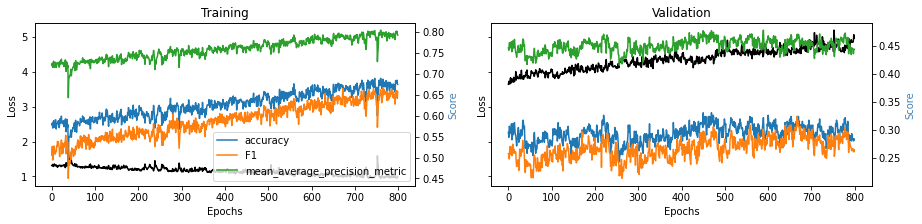

In [15]:
# plot
metrics = [k for k in history.history.keys() if ("loss" not in k) and ("val" not in k)]
fig, ax = plt.subplots(nrows=1, ncols=2, sharey=True, figsize=(15,3))

## training
ax[0].set(title="Training")
ax11 = ax[0].twinx()
ax[0].plot(history.history['loss'], color='black')
ax[0].set_xlabel('Epochs')
ax[0].set_ylabel('Loss', color='black')
for metric in metrics:
    ax11.plot(history.history[metric], label=metric)
    ax11.set_ylabel("Score", color='steelblue')
ax11.legend()

## validation
ax[1].set(title="Validation")
ax22 = ax[1].twinx()
ax[1].plot(history.history['val_loss'], color='black')
ax[1].set_xlabel('Epochs')
ax[1].set_ylabel('Loss', color='black')
for metric in metrics:
    ax22.plot(history.history['val_'+metric], label=metric)
    ax22.set_ylabel("Score", color="steelblue")
plt.show()